# Per-feature metrics & plots (real vs synthetic windows)

This notebook computes per-feature DTW, MMD (RBF kernel), KS test, mean/variance differences, and saves CSV + bar charts. It uses `fastdtw` if available; otherwise falls back to an exact DP implementation (slower).


In [1]:
import os
os.chdir(r"C:\Local Disk D\BDA_CEP_Part-2")
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from scipy.stats import ks_2samp

# optional: reproducibility for sampling
SEED = 42
rng = np.random.default_rng(SEED)
np.random.seed(SEED)


## Paths and directories
Adjust paths if you store files elsewhere.


In [2]:
REAL_PATH = "data/processed/electricity/test.npy"
SYNTH_PATH = "outputs/synth/synth_electricity_2000w.npy"
SCALER_PATH = "data/processed/electricity/scaler.pkl"
FEAT_PATH = "data/processed/electricity/features.txt"
OUT_CSV = "outputs/eval/feature_metrics_with_plots.csv"
OUT_DIR = "outputs/figures/feature_metrics"

os.makedirs(OUT_DIR, exist_ok=True)
os.makedirs(os.path.dirname(OUT_CSV), exist_ok=True)

required = [REAL_PATH, SYNTH_PATH, SCALER_PATH, FEAT_PATH]
missing = [p for p in required if not os.path.exists(p)]
if missing:
    raise FileNotFoundError("Missing required files: " + ", ".join(missing))
print("All required files present. Outputs:", OUT_CSV, OUT_DIR)


All required files present. Outputs: outputs/eval/feature_metrics_with_plots.csv outputs/figures/feature_metrics


## Optional: try fastdtw for speed


In [3]:
try:
    from fastdtw import fastdtw
    use_fastdtw = True
except Exception:
    use_fastdtw = False
print("Using fastdtw:", use_fastdtw)


Using fastdtw: True


## Load data and convert synth to scaled space
- `real` is expected in scaled space (same scale used by training / embedder).
- `synth_inv` is in original units; we convert it to scaled space for distributional comparisons.


In [4]:
real = np.load(REAL_PATH)            # scaled, shape (n_real, T, D)
synth_inv = np.load(SYNTH_PATH)      # inverse-scaled original units (n_synth, T, D)
feat_names = open(FEAT_PATH).read().splitlines()
scaler = pickle.load(open(SCALER_PATH, "rb"))

# convert synth to scaled space (same input domain as real)
synth_scaled = scaler.transform(synth_inv.reshape(-1, synth_inv.shape[2])).reshape(synth_inv.shape)

n_feat = real.shape[2]
print(f"Loaded real {real.shape}, synth {synth_inv.shape}, features={n_feat}")


Loaded real (216, 168, 7), synth (2000, 168, 7), features=7


## Helpers
- DTW (fast if fastdtw installed; exact DP fallback)
- MMD over windows (rows) using RBF; median heuristic for sigma


In [5]:
# DTW helpers
def dtw_distance_fast(a, b):
    """Return DTW distance between 1D arrays a and b."""
    if use_fastdtw:
        dist, _ = fastdtw(a, b)
        return float(dist)
    else:
        n, m = len(a), len(b)
        dtw = np.full((n+1, m+1), np.inf, dtype=float)
        dtw[0, 0] = 0.0
        for i in range(1, n+1):
            ai = a[i-1]
            # inner loop over j
            for j in range(1, m+1):
                cost = abs(ai - b[j-1])
                dtw[i, j] = cost + min(dtw[i-1, j], dtw[i, j-1], dtw[i-1, j-1])
        return float(dtw[n, m])

# MMD over windows (each row is a window)
def mmd_rbf_windows(X, Y, sigma=None):
    """
    X: (n_x, T) rows = windows
    Y: (n_y, T)
    returns (mmd_value, sigma_used)
    """
    xx = cdist(X, X, 'sqeuclidean')
    yy = cdist(Y, Y, 'sqeuclidean')
    xy = cdist(X, Y, 'sqeuclidean')

    if sigma is None:
        triu_idx = np.triu_indices_from(xx, k=1)
        vals = xx[triu_idx]
        med = np.median(vals) if vals.size > 0 else 1.0
        sigma = np.sqrt(med) if med > 0 else 1.0

    Kxx = np.exp(-xx / (2 * sigma**2))
    Kyy = np.exp(-yy / (2 * sigma**2))
    Kxy = np.exp(-xy / (2 * sigma**2))
    mmd = float(Kxx.mean() + Kyy.mean() - 2 * Kxy.mean())
    return mmd, float(sigma)


## Compute metrics per feature
We compute:
- MMD between windows
- KS on pooled timepoints (marginal)
- mean/variance difference (scaled)
- average DTW over sampled pairs (to speed up)


In [6]:
rows = []
K_pairs = 20
num_real = real.shape[0]
num_synth = synth_scaled.shape[0]

for fi, name in enumerate(feat_names):
    real_windows = real[:, :, fi]         # (n_real, T)
    synth_windows = synth_scaled[:, :, fi]# (n_synth, T)

    # MMD between windows
    mmd_val, sigma = mmd_rbf_windows(real_windows, synth_windows, sigma=None)

    # KS on flattened marginals
    ks = ks_2samp(real_windows.ravel(), synth_windows.ravel())

    # mean/var diffs
    mean_diff = float(abs(real_windows.ravel().mean() - synth_windows.ravel().mean()))
    var_diff = float(abs(real_windows.ravel().var() - synth_windows.ravel().var()))

    # DTW sampled pairs
    dtw_vals = []
    for _ in range(K_pairs):
        i = int(rng.integers(0, num_real))
        j = int(rng.integers(0, num_synth))
        a = real_windows[i, :]
        b = synth_windows[j, :]
        dtw_vals.append(dtw_distance_fast(a, b))
    avg_dtw = float(np.mean(dtw_vals))
    std_dtw = float(np.std(dtw_vals))

    rows.append({
        "Feature": name,
        "Avg DTW": avg_dtw,
        "DTW std": std_dtw,
        "MMD (RBF)": mmd_val,
        "MMD sigma": sigma,
        "KS stat": float(ks.statistic),
        "KS pval": float(ks.pvalue),
        "Mean diff": mean_diff,
        "Var diff": var_diff
    })
    print(f"Computed {name}: DTW={avg_dtw:.2f} (±{std_dtw:.2f}), MMD={mmd_val:.6f}, KS={ks.statistic:.4f}")


Computed Global_active_power: DTW=107.22 (±15.44), MMD=0.155002, KS=0.5790
Computed Global_reactive_power: DTW=117.93 (±34.40), MMD=0.079930, KS=0.4092
Computed Voltage: DTW=95.01 (±48.52), MMD=0.192923, KS=0.5137
Computed Global_intensity: DTW=108.19 (±16.05), MMD=0.152203, KS=0.5738
Computed Sub_metering_1: DTW=84.17 (±16.13), MMD=0.080466, KS=0.8724
Computed Sub_metering_2: DTW=49.97 (±7.89), MMD=0.072607, KS=0.6307
Computed Sub_metering_3: DTW=145.68 (±18.05), MMD=0.132802, KS=0.6108


## Save CSV and bar plots


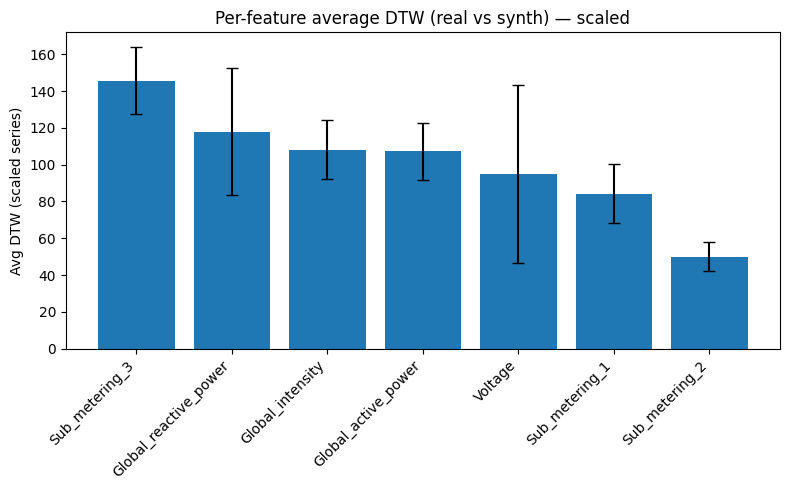

Saved DTW bar chart to: outputs/figures/feature_metrics\per_feature_dtw.png


In [8]:
# %%
# Cell A - Per-feature DTW bar chart (sorted, with std error)
import os
import numpy as np
import matplotlib.pyplot as plt

# df, OUT_DIR expected to exist
os.makedirs(OUT_DIR, exist_ok=True)

df = pd.DataFrame(rows)

df_sorted = df.sort_values("Avg DTW", ascending=False).reset_index(drop=True)
labels = df_sorted["Feature"].tolist()
x = np.arange(len(labels))

plt.figure(figsize=(max(8, len(labels)*0.6), 5))
plt.bar(x, df_sorted["Avg DTW"], yerr=df_sorted["DTW std"], capsize=4)
plt.xticks(x, labels, rotation=45, ha="right")
plt.ylabel("Avg DTW (scaled series)")
plt.title("Per-feature average DTW (real vs synth) — scaled")
plt.tight_layout()

dtw_png = os.path.join(OUT_DIR, "per_feature_dtw.png")
plt.savefig(dtw_png, dpi=200, bbox_inches="tight")
plt.show()
plt.close()
print("Saved DTW bar chart to:", dtw_png)


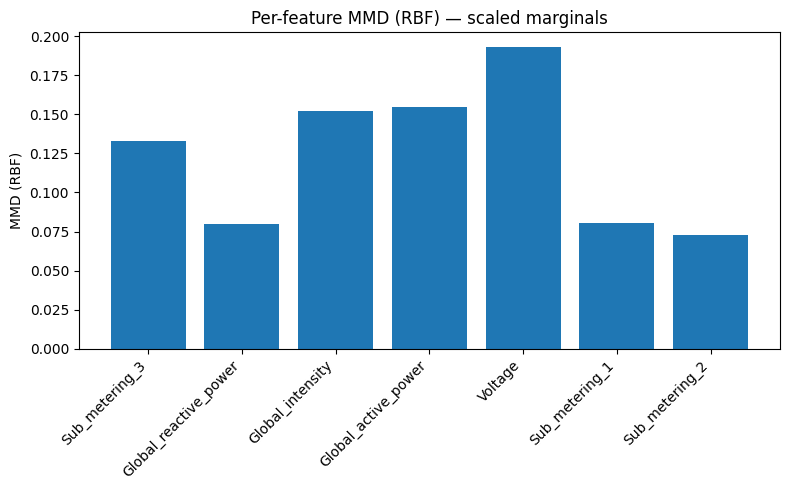

Saved MMD bar chart to: outputs/figures/feature_metrics\per_feature_mmd.png


In [9]:
# %%
# Cell B - Per-feature MMD bar chart
import os
import matplotlib.pyplot as plt

df = pd.DataFrame(rows)

# df_sorted and labels assumed available; recompute if running this cell standalone
df_sorted = df.sort_values("Avg DTW", ascending=False).reset_index(drop=True)
labels = df_sorted["Feature"].tolist()
x = np.arange(len(labels))

plt.figure(figsize=(max(8, len(labels)*0.6), 5))
plt.bar(x, df_sorted["MMD (RBF)"])
plt.xticks(x, labels, rotation=45, ha="right")
plt.ylabel("MMD (RBF)")
plt.title("Per-feature MMD (RBF) — scaled marginals")
plt.tight_layout()

mmd_png = os.path.join(OUT_DIR, "per_feature_mmd.png")
plt.savefig(mmd_png, dpi=200, bbox_inches="tight")
plt.show()
plt.close()
print("Saved MMD bar chart to:", mmd_png)


In [10]:
# %%
# Cell C - Save and display LaTeX-friendly table from df
import os
from IPython.display import display
df = pd.DataFrame(rows)
df.to_csv(OUT_CSV, index=False)
print("Saved per-feature CSV to:", OUT_CSV)

# Ensure df and OUT_CSV exist
latex_path = OUT_CSV.replace(".csv", ".tex") if OUT_CSV.endswith(".csv") else os.path.join(OUT_DIR, "per_feature_metrics.tex")

# Save LaTeX table
with open(latex_path, "w") as f:
    f.write(df.to_latex(index=False, float_format="%.4f", caption="Per-feature metrics: DTW, MMD, KS, mean/var diffs."))

print("Saved LaTeX table to:", latex_path)

# Display the DataFrame in the notebook
print("\nPreview of per-feature metrics table:")
display(df.round(4))


Saved per-feature CSV to: outputs/eval/feature_metrics_with_plots.csv
Saved LaTeX table to: outputs/eval/feature_metrics_with_plots.tex

Preview of per-feature metrics table:


,Feature,Avg DTW,DTW std,MMD (RBF),MMD sigma,KS stat,KS pval,Mean diff,Var diff
0,Global_active_power,107.2185,15.4427,0.1550,12.3027,0.5790,0.0,0.1360,0.5651
1,Global_reactive_power,117.9345,34.4026,0.0799,16.6195,0.4092,0.0,0.1500,0.9229
2,Voltage,95.0073,48.5238,0.1929,10.2358,0.5137,0.0,0.2240,0.5956
3,Global_intensity,108.1923,16.0549,0.1522,12.2814,0.5738,0.0,0.1251,0.5615
4,Sub_metering_1,84.1750,16.1269,0.0805,14.2008,0.8724,0.0,0.1138,0.7006
5,Sub_metering_2,49.9741,7.8935,0.0726,11.9193,0.6307,0.0,0.1243,0.4697
6,Sub_metering_3,145.6781,18.0517,0.1328,15.8517,0.6108,0.0,0.0673,0.9040


## Notes & tuning tips
- MMD sigma uses a median heuristic (sqrt of median squared-dist). If MMD values look tiny or huge, try fixing sigma manually.
- DTW sampling: K_pairs trades compute time vs variance. Increase for more stable estimates.
- If dataset large, compute MMD on a random subset of windows (deterministic seed used above).
- If you want inline plots, remove `plt.close()` and run the plotting cells interactively.
